# MEGN 570 HW 4 - Charge Transfer Modeling

We will model charge transfer at an SOFC anode, where O$^{2-}$ in the electrolyte reacts with 2 hydrogen atoms adsorbed on a Ni surface (H$_{\rm Ni(s)}$) to form adsorbed water (H$_2$O$_{\rm Ni(s)}$) and electrons in the Ni (e$^-_{\rm Ni}$).

$$\mathrm{O^{2-}_{elyte(s)} + 2\,H_{Ni(s)} \leftrightarrows \left[\,\right]_{elyte(s)} + H_2O_{Ni(s)} + \left[\,\right]_{Ni(s)}+ 2\,e^-_{Ni}  }$$

where $\left[\,\right]_{\rm elyte}$ is a surface vacancy on the ceramic electrolyte surface, where the oxide formerly resided, and $ \left[\,\right]_{Ni(s)}$ is a vacancy on the Ni surface.  

We are going to plot the charge transfer current density as a function of the double layer potential $\Delta\phi = \phi_{\rm an} - \phi_{\rm elyte}$ for $-1.0 \leq \Delta \phi \leq 0.15\,{\rm V}$.

For this reaction, the standard concentration for the Ni surface is the total site density, $C^\circ_{\rm Ni(s)} = \Gamma_{\rm Ni(s)} = 2.6\times10^{-8}\,\frac{\rm kmol}{m^2}$, and for the electrolyte it is the total electrolyte surface site density: $C_{\rm elyte}^\circ =\Gamma_{\rm YSZ(s)} =  46.05\,\frac{\rm kmol}{\rm m^2}$

The species thermo and forward rate coefficient are provided for you.

## Part 1:  Elementary mass action kinetics.

Calculate the current density as a function of the electric potential, using elementary mass-action kinetics.  The only requirement is that you provide an equation for `i_elementary[i]`, which calculates the current density (A m%^{-2}$) for each electric potential value.  How you get to that value is up to you.

The actual answers are plotted with your equation, to verify.  

Note that we define positive current as positive charge moving _to_ the electrode, and the electric potential as $\Delta \phi = \phi_{\rm an} - \phi_{\rm elyte}$.  As we are sweeping from $\Delta \phi=0.15$ to $\Delta \phi = -1.0$, should the current get more positive or more negative?

Assume the following conditions:

- $\theta_{\rm H_{Ni(s)}} = 0.6$
- $\theta_{\rm H_2O_{Ni(s)}} = 0.2$
- $\theta_{\rm \left[\,\right]_{Ni(s)}} = 0.2$
- $\theta_{\rm O^{2-}_{elyte(s)}} = 0.92$
- $\theta_{\rm \left[\,\right]_{elyte(s)}} = 0.08$
- $T = 800^\circ$ C

The $k_{\rm fwd}$ value given below is in units that will results in a current given in A m$^{-2}$.

### Import modules:

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, log

### Givens

In [5]:
F = 96485e3    # Faraday's constant, C/kmol equivalent charge
R = 8314.5     # Gas constant, J/kmol-K

k_fwd_star = 4.16307062e+7 # Chemical forward rate constant, m^4/kmol^2/s

C_elyte = 46.05    # Total (reference) elyte concentration, kmol/m3
C_Ni_s = 2.6e-08   # Total (reference) concentration of Ni surface sites, kmol/m2

X_H_Ni = 0.6
X_H2O_Ni = 0.2
X_Vac_Ni = 0.2
X_Vac_elyte = 0.08
X_Ox_elyte = 0.92

"Species standard-state thermo"
g_H_Ni_o = -7.109209e+07      # standard-state gibbs energy for H adsorbed on Ni surface (J/kmol)
g_H2O_Ni_o = -3.97403035e+08  # standard-state gibbs energy for H2O adsorbed on Ni surface (J/kmol)
g_Vac_Ni_o = 0.0              # standard-state gibbs energy for Ni surface vacancy (J/kmol)
g_Vac_elyte_o = 0.0           # standard-state gibbs energy for electrolyte oxide vacancy (J/kmol)
g_Ox_elyte_o = -2.1392135e+08 # standard-state gibbs energy for electrolyte oxide O2- (J/kmol)

# Validated (i.e. correct :) results.  We will use these to check our answers:
E_validate = np.array([-0.9, -0.86724138, -0.83448276, -0.80172414, -0.76896552, 
                    -0.7362069, -0.70344828, -0.67068966, -0.63793103, -0.60517241, 
                    -0.57241379, -0.53965517, -0.50689655, -0.47413793, -0.44137931, 
                    -0.40862069, -0.37586207, -0.34310345, -0.31034483, -0.27758621, 
                    -0.24482759, -0.21206897, -0.17931034, -0.14655172,  -0.1137931, 
                    -0.08103448, -0.04827586, -0.01551724,  0.01724138,  0.05])
i_validate = np.array([ 131.74413417,   92.44282478,   64.86313049,   45.50798636,   31.9231884,
                    22.38620407,   15.68775772,   10.97849611,    7.66129177,    5.31552803,
                    3.64376548,    2.43402707,    1.53291973,    0.82618438,    0.22420799,
                    -0.34933914,   -0.96718197,   -1.70766206,   -2.66467121,   -3.95955677,
                    -5.75650834,   -8.28337676,  -11.86056524,  -16.94165607,  -24.17092413,
                    -34.46503005,  -49.12925142,  -70.02299007,  -99.79554155, -142.22202185])

### Notes for the below calculation:
$\frac{k^*_{\mathrm{fwd}}}{k^*_{\mathrm{rev}}} = \exp(-\frac{\Delta G^{\circ}_{\mathrm{rxn}}}{RT}) \prod_mC_{\mathrm m}^{\circ\sum_{\mathrm{k,m}}{\nu_\mathrm k}} $

Below is the above equation rearranged such that $k^*_{\mathrm{rev}}$ is a function of $k^*_{\mathrm{fwd}}$

$k^*_{\mathrm{rev}} = \frac{k^*_{\mathrm{fwd}}}{\exp(-\frac{\Delta G^\circ_{\mathrm{rxn}}}{RT})*\prod_mC_{\mathrm m}^{\circ\sum_{\mathrm{k,m}}{\nu_\mathrm k}}}$

The masss action equation is:$i_\mathrm{M-A} = n_{elec}*F(k_{\mathrm{fwd}}\prod_mC_\mathrm{ac,k}^{\nu^\prime_\mathrm{k}}-k_{\mathrm{rev}}\prod_mC_\mathrm{ac,k}^{\nu^{\prime\prime}_\mathrm{k}}) $

Where $k_\mathrm{fwd} = k^*_\mathrm{fwd}\exp{(\frac{-\beta n_\mathrm{elec}F\Delta\phi}{RT})}$

and $k_\mathrm{rev} = k^*_\mathrm{fwd}\exp{(\frac{(1-\beta) n_\mathrm{elec}F\Delta\phi}{RT})}$

Thus the final mass action equation is: $i_\mathrm{M-A} = n_{elec}*F(k^*_\mathrm{fwd}\exp{(\frac{-\beta n_\mathrm{elec}F\Delta\phi}{RT})}\prod_mC_\mathrm{ac,k}^{\nu^\prime_\mathrm{k}}-k^*_\mathrm{fwd}\exp{(\frac{(1-\beta) n_\mathrm{elec}F\Delta\phi}{RT})}\prod_mC_\mathrm{ac,k}^{\nu^{\prime\prime}_\mathrm{k}})$

The activity concentrations are:
$C_{ac,k} = \Gamma_o*\theta_k$


In [7]:
# Loop over these delta phi = phi_anode - phi_elyte values:
delta_phi = np.linspace(-0.9,0.05,100)
i_elementary = np.zeros_like(delta_phi)

#Stoichiometric coefficients
nu_H_Ni = -2
nu_H2O_Ni = 1
nu_Vac_Ni = 1
nu_Vac_elyte = 1
nu_Ox_elyte = -1

#Concentrations:
C_H_Ni = X_H_Ni*C_Ni_s
C_H2O_Ni = X_H2O_Ni*C_Ni_s
C_Vac_Ni = X_Vac_Ni*C_Ni_s
C_Vac_elyte = X_Vac_elyte*C_elyte
C_Ox_elyte = X_Ox_elyte*C_elyte

#Not-given variables
T = 1073 #K
n = -2 #mol e-, 2 positive charges are leaving the anode
beta = 0.5 #no units, assumed

#Values that need to be calculated to solve for io: (Delta_g_naught and k_rev)
DGo = g_H2O_Ni_o+(g_Ox_elyte_o*nu_Ox_elyte)+(nu_H_Ni*g_H_Ni_o) #(J/kmol)Delta G naught
prod_cm = C_elyte**(nu_Ox_elyte+nu_Vac_elyte) * C_Ni_s**(nu_H_Ni+nu_H2O_Ni+nu_Vac_Ni)
k_rev_star = k_fwd_star/(math.exp(-DGo/(R*T))*prod_cm)

#Products used in the mass action equation:
prod_fwd = C_Ox_elyte**(-nu_Ox_elyte) * C_H_Ni**(-nu_H_Ni) #added negative signs to cancel out the origional negative sign that was there if the calculation was only looking at nu_k
prod_rev = C_H2O_Ni**nu_H2O_Ni * C_Vac_Ni**nu_Vac_Ni * C_Vac_elyte**nu_Vac_elyte

print(k_rev_star)
print(prod_cm)
#Delta G equation:
DG_rxn = DGo + R*T*math.log((C_H2O_Ni**nu_H2O_Ni)*(C_Ox_elyte**nu_Ox_elyte)*(C_H_Ni**nu_H_Ni)*(C_Vac_elyte**nu_Vac_elyte)*(C_Vac_Ni**nu_Vac_Ni))
#deltaphiEq:
Dphi_eq = -DG_rxn/(n*F)
print('Δφ_rxn \u2248',round(Dphi_eq,2),'V')

for ind, E in enumerate(delta_phi):
    #reaction rate constants
    k_fwd = k_fwd_star*math.exp(-(beta*n*F*delta_phi[ind])/(R*T))
    k_rev = k_rev_star*math.exp(((1-beta)*n*F*delta_phi[ind])/(R*T))
    
    #using the mass action equation to calculate the current density
    i_elementary[ind] = n*F*((k_fwd*prod_fwd)-(k_rev*prod_rev))
    

406500.4571586435
1.0
Δφ_rxn ≈ -0.43 V


Plot the results:

Text(0, 0.5, 'Current [A/m2]')

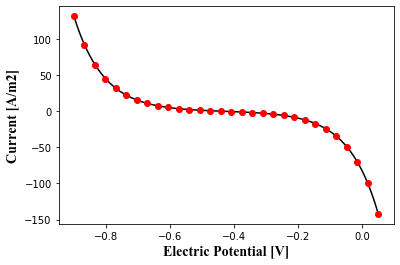

In [8]:
fig1, ax1 = plt.subplots()
ax1.plot(delta_phi,i_elementary,linewidth = 1.5,color = 'k')
ax1.plot(E_validate,i_validate,'ro',linewidth = 1.5)
ax1.set_xlabel('Electric Potential [V]',family='Times New Roman',fontsize=14)
ax1.set_ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)

Text(0, 0.5, 'Current [A/m2]')

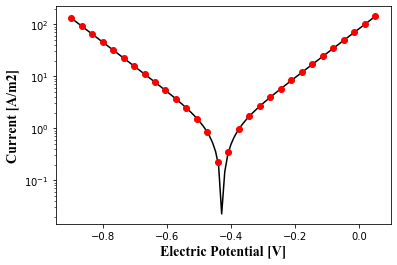

In [9]:
fig2, ax2 = plt.subplots()
ax2.semilogy(delta_phi,abs(i_elementary),linewidth = 1.5,color = 'k')
ax2.semilogy(E_validate,abs(i_validate),'ro',linewidth = 1.5)
ax2.set_xlabel('Electric Potential [V]',family='Times New Roman',fontsize=14)
ax2.set_ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)

### Discussion: 
The plots for calculating the electric potential vs current density while using the mass action equation closely match the validation data. They also do make sense with my understanding of the theory.  One point of interest on the chart is where the applied electric potential is equal to the thermodynamic chemical potential which corresponds to the open circut voltage (OCV).  At the OCV, there should be no current flow because the two driving forces equally oppose each other. In the example above, the driving force for this reaction, Delta G, is roughly -0.43V. So at roughly -0.43 Volts of applied potential there should be no current flow. Figure 2 validates this claim.

Further it makes sense that the larger the difference between the applied voltage and the equlibrium voltage (dictated by thermydynamics) the larger the current flowing through the cell.  Also since $\Delta\phi$ is in an exponential, as it grows the current should grow exponentially which it does. While on the subject of exponential growth, when $\Delta\phi$ approaches $\Delta\phi_\mathrm{eq}$ the equation decays exponentially which makes sense given the nature of the equations.
    
Figure 2 Reminds me of the Tafel equation. While it is plotted as the electric potential instead of overpotential as a function of log current, it shows a similar trend. The main difference between a Tafel plot and firgue 2 is that figure 2 is shifted on the x-axis by the thermodynamic potential. Both plots show that at high overpotentials, log current is linear with overpotential, and this is due to the fact that one exponential in the equation will be much larger in the other and will dominate the results. At low overpotentials, both exponentials contribute to the currrent. The tafel equation just takes the smaller exponential out entirely to make the equation more simple.
    
Last it makes sense that there is two different current directions. If the thermodynamic chemical driving force is greater than the electrostatic driving force, then current will flow in the chemically favorable direction.  If the opposite is true, then the current will follow the. The forward and reverse sides of the plots are the same because $\beta$ is 0.5.

## ii. Part 2: Butler-Volmer kinetics  

Now use your derivation to calculate $i_\circ$ as a function of your elementary kinetic parameters, and then calculate the currents for the same range of potentials.

Equation: $i_\mathrm{BV}=i_\circ(\exp{(\frac{-\beta nF\eta}{RT})}-\exp{(\frac{(1-\beta)nF\eta}{RT})})$

Where $i_o = n_\mathrm{elec}Fk^{*(1-\beta)}_\mathrm{fwd}k^{*\beta}_\mathrm{rev}\prod_mC_\mathrm{ac,k}^{(1-\beta)\nu^\prime_\mathrm{k}}\prod_mC_\mathrm{ac,k}^{\beta\nu^{\prime\prime}_\mathrm{k}}$

In [10]:
i_BV = np.zeros_like(delta_phi)

#i_o calculation
i_o = n*F*(k_fwd_star**(1-beta))*(k_rev_star**beta)*(prod_fwd**(1-beta))*(prod_rev**beta)
print(i_o)

for ind, E in enumerate(delta_phi):
    #solving for eta:
    eta = delta_phi[ind]-Dphi_eq
    
    i_BV[ind] = i_o*(math.exp(-beta*n*F*eta/R/T)-math.exp((1-beta)*n*F*eta/R/T))

-0.8044956288601341


#### Let's plot the BV and Marcus currents together:

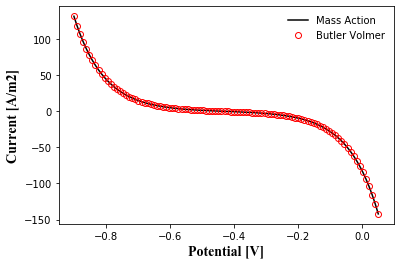

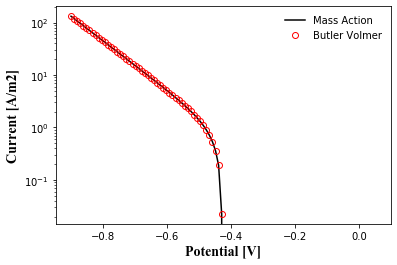

(-0.4, -0.45)

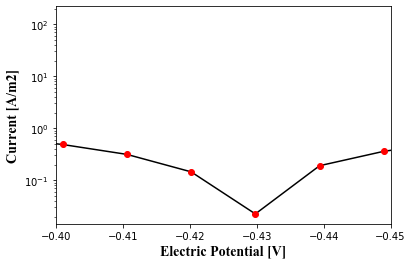

In [11]:
plt.close('all')
plt.plot(delta_phi,i_elementary,linewidth = 1.5,color = 'k');
plt.plot(delta_phi,i_BV,'ro',markerfacecolor='none');
plt.xlabel('Potential [V]',family='Times New Roman',fontsize=14)
plt.ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)
plt.legend(['Mass Action','Butler Volmer'],frameon=False)
plt.show()

plt.close('all')
plt.semilogy(delta_phi,i_elementary,linewidth = 1.5,color = 'k');
plt.semilogy(delta_phi,i_BV,'ro',markerfacecolor='none');
plt.xlabel('Potential [V]',family='Times New Roman',fontsize=14)
plt.ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)
plt.legend(['Mass Action','Butler Volmer'],frameon=False)
plt.show()

fig3, ax3 = plt.subplots()
ax3.semilogy(delta_phi,abs(i_elementary),linewidth = 1.5,color = 'k')
ax3.semilogy(delta_phi,abs(i_BV),'ro',linewidth = 1.5)
ax3.set_xlabel('Electric Potential [V]',family='Times New Roman',fontsize=14)
ax3.set_ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)
plt.xlim(-0.4,-0.45)

#### Discussion:

The plots are the same. Since, $i_o = n_\mathrm{elec}Fk^{*(1-\beta)}_\mathrm{fwd}k^{*\beta}_\mathrm{rev}\prod_mC_\mathrm{ac,k}^{(1-\beta)\nu^\prime_\mathrm{k}}\prod_mC_\mathrm{ac,k}^{\beta\nu^{\prime\prime}_\mathrm{k}}$ the graphs should have been the same as was painstakingly proved in the written portion. Most noteworthy results were discussed above, since the mass action and Butler-Volmer equations are so similar. The third figure was made because near $\Delta\phi_\mathrm{eq}$ it looked like the mass action and Butler-Volmer results were differing, but that is not the case.

How do you feel about the assumption of constant $i_\circ$?  Are there situations where this is _not_ a good assumption?
I feel that for the most part $i_\circ$ being constant is a good assumption. However as the overpotentials get bigger this assumption breaks down.  Current can not increase forever, as the voltage increaess so do the cell losses lowering $i_\circ$. Also, $i_\circ$ is dependend on reactant concentration, temperature, and the activation barrier, If any of these values change as a result of operation $i_\circ$ will change with them.

### C. Tafel current

We can re-use the same parameters ($i_\circ$, $\beta$, etc.) from the Butler-Volmer expression to calculate the current using the Tafel approximation: $i\approx i_\circ\exp(\frac{\alpha F\eta}{RT})$

In [12]:
i_Tafel = np.zeros_like(delta_phi)
alpha = -n*beta
for ind, E in enumerate(delta_phi):
    eta = delta_phi[ind]-Dphi_eq
    i_Tafel[ind] = i_o*math.exp(alpha*F*eta/(R*T))

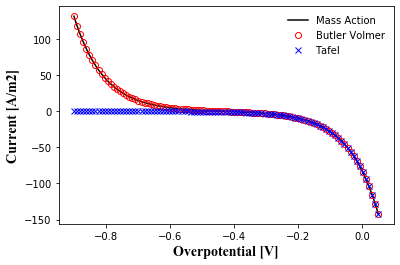

In [13]:
plt.plot(delta_phi,i_elementary,linewidth = 1.5,color = 'k');
plt.plot(delta_phi,i_BV,'o',markeredgecolor='r',markerfacecolor='none');
plt.plot(delta_phi,i_Tafel,'x',markeredgecolor='b',markerfacecolor='none');
plt.xlabel('Overpotential [V]',family='Times New Roman',fontsize=14)
plt.ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)
plt.legend(['Mass Action','Butler Volmer','Tafel'],frameon=False)
plt.show()

### Disucssion: 
What do you notice, from these results?  What from the theory can explain what you sese.

#### Play with the limits, below, to highlight trends which support your discussion claims.

Feel free to copy the following code block and zoom in on different regions.

In [ ]:
plt.plot(delta_phi,i_elementary,linewidth = 1.5,color = 'k');
plt.plot(delta_phi,i_BV,'o',markeredgecolor='r',markerfacecolor='none');
plt.plot(delta_phi,i_Tafel,'x',markeredgecolor='b',markerfacecolor='none');
plt.xlabel('Electric Potential [V]',family='Times New Roman',fontsize=14)
plt.ylabel('Current [A/m2]',family='Times New Roman',fontsize=14)
plt.legend(['Mass Action','Butler Volmer','Tafel'],frameon=False)
plt.xlim((-0.6,0.1))
plt.ylim((-100,0))
plt.show()

#### Discussion:
